# Creating baseline performance for MPI


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
#import hvplot.xarray
import sys

%matplotlib inline

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

sys.path.insert(0, '../../src')

from utils import df_to_xarray,read_xarray

/burg/glab/users/sk4973/venv2/lib/python3.8/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(
2022-12-12 11:20:54.180205: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/shared/apps/slurm/current/lib64/slurm:/cm/shared/apps/slurm/current/lib64
2022-12-12 11:20:54.180225: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
mpi_data_path = "../../data/mpi_001"

dist_map = pd.read_csv("../../src/dist_map.csv",header=None).to_numpy()
dist_map = np.roll(np.fliplr(dist_map),180)
dist_map = np.repeat(dist_map[np.newaxis, :, : ], 421, axis=0)

def read_xarray_mpi(dir_name="",num="006"):
    '''
     read_xarray(dir)name) opens data and returns data in xarray format for each feature
    '''
    date="198201-201701"
  
    file_type ="MPI"
        
    chl = xr.open_dataset(f'{dir_name}/Chl_2D_mon_{file_type}{num}_1x1_{date}.nc')

    mld = xr.open_dataset(f'{dir_name}/MLD_2D_mon_{file_type}{num}_1x1_{date}.nc')

    sss = xr.open_dataset(f'{dir_name}/SSS_2D_mon_{file_type}{num}_1x1_{date}.nc')

    sst = xr.open_dataset(f'{dir_name}/SST_2D_mon_{file_type}{num}_1x1_{date}.nc')

    xco2 = xr.open_dataset(f'../../data/member_001/XCO2_1D_mon_CESM001_native_198201-201701.nc')

    pco2 = xr.open_dataset(f'{dir_name}/pCO2_2D_mon_{file_type}{num}_1x1_{date}.nc')

    return chl,mld,sss,sst,xco2,pco2


chl,mld,sss,sst,xco2,pco2 = read_xarray_mpi(mpi_data_path)
xco2=xco2.isel(bnds=0)
xco2['time'] = xco2.indexes['time'].to_datetimeindex().strftime("%Y-%m")

/burg/glab/users/sk4973/venv2/lib/python3.8/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'cfgrib' loading failed:
ecCodes library not found using ['eccodes', 'libeccodes.so', 'libeccodes']
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
/tmp/ipykernel_1015925/1737620885.py:32: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  xco2['time'] = xco2.indexes['time'].to_datetimeindex().strftime("%Y-%m")


In [3]:
pco2['time'] = pco2.time.dt.strftime("%Y-%m")
chl['time'] = chl.time.dt.strftime("%Y-%m")
mld['time'] =mld.time.dt.strftime("%Y-%m")
sss['time'] =sss.time.dt.strftime("%Y-%m")
sst['time'] =sst.time.dt.strftime("%Y-%m")

In [4]:
data_read=xr.merge([chl.Chl,chl.Chl_socat,mld.MLD,mld.MLD_socat,sst.SST,sst.SST_socat,
                    sss.SSS,sss.SSS_socat,xco2,pco2.pCO2,pco2.pCO2_socat])
tmp_data=data_read.to_dataframe().reset_index()

In [5]:
tmp_data=tmp_data.drop(columns=['TLONG', 'TLAT', 'time_bnds'])

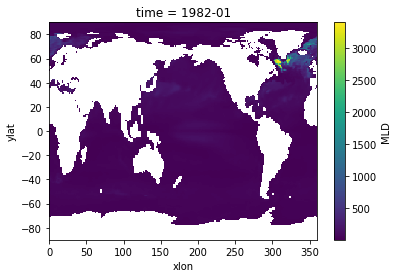

In [6]:
check=tmp_data.set_index(["time","ylat","xlon"]).to_xarray()
check.MLD[0].plot()

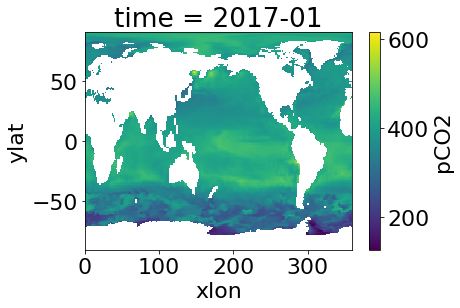

In [52]:
check.pCO2[420].plot()

In [7]:
tmp_data_final=tmp_data[tmp_data.time != "1982-01"]
tmp_data_final=tmp_data_final[tmp_data_final.time != "2017-02"]

In [21]:
features_socat = ['time','xlon', 'ylat', 'SST_socat', 'SSS_socat','Chl_socat', 'XCO2','pCO2_socat']
features = ['time','xlon', 'ylat','SST','SSS','Chl','XCO2','pCO2']

# create separate dataframe for socat
combined_socat=tmp_data_final[features_socat]
combined=tmp_data_final[features]

In [22]:
# drop rows where pco2 or pco2_socat == NA or 0
combined_socat.dropna(subset = ["pCO2_socat"],inplace=True)
combined_socat= combined_socat[(combined_socat['pCO2_socat']!=0)&(combined_socat['pCO2_socat']<650)]

combined.dropna(subset = ["pCO2"],inplace=True)
combined= combined[(combined['pCO2']!=0)&(combined['pCO2']<650)]

/burg/glab/users/sk4973/venv2/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [23]:
combined.head()

,time,xlon,ylat,SST,SSS,Chl,XCO2,pCO2
64819,1982-02,0.5,-70.5,1.956964,33.415752,0.616617,340.848541,306.208160
64820,1982-02,0.5,-69.5,3.334100,33.930805,4.312912,340.848541,229.071625
64821,1982-02,0.5,-68.5,4.098901,34.208809,0.696006,340.848541,273.257538
64822,1982-02,0.5,-67.5,4.267999,34.219513,0.450442,340.848541,298.436462
64823,1982-02,0.5,-66.5,4.173761,34.232868,0.256637,340.848541,291.384857


In [24]:
X_socat=combined_socat.iloc[:,1:-1]
X=combined.iloc[:,1:-1]
y=combined.loc[:,'pCO2']
y_socat=combined_socat.loc[:,'pCO2_socat']

In [25]:
combined.xlon.min(),combined.xlon.max(),combined.ylat.min(),combined.ylat.max()

(0.5, 359.5, -77.5, 89.5)

In [26]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
X=imp.fit_transform(X)
X_socat=imp.fit_transform(X_socat)

In [27]:
X_socat.shape[0]/X.shape[0]*100

1.4128265590323683

In [28]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

X_train, X_test, y_train, y_test = train_test_split(X_socat, y_socat, test_size=0.3, random_state= 73)

regressor=RandomForestRegressor(n_estimators=20, random_state=42, verbose=3,n_jobs=-1, 
                                max_depth=10,warm_start= True)
regressor.fit(X_train, y_train)


forest_scores = cross_val_score(regressor, X_train, y_train,
                                scoring="neg_mean_squared_error", cv=3)
forest_rmse_scores = np.sqrt(-forest_scores)

display_scores(forest_rmse_scores)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 20
building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    2.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    3.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[P

Scores: [18.53259904 18.61402096 18.48814509]
Mean: 18.54492169692486
Standard deviation: 0.052122096903602276


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.0s finished


In [29]:
y_pred=regressor.predict(X_test)
test_mse=mean_squared_error(y_test, y_pred,squared=True)
np.sqrt(test_mse)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.0s finished


18.537978313994756

In [30]:
y_pred=regressor.predict(X)
final_test_rmse=np.sqrt(mean_squared_error(y, y_pred,squared=True))
error=y-y_pred

final_test_rmse

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    2.7s finished


32.51447226813666

In [64]:
## Full Data
# rmse with MLD : 40.462 uatm -> 31.9733 uatm
# rmse with Dist : 41.541 uatm -> 32.84 uatm with coordinate

## Socat 
# # rmse with MLD : on full  348.32 uatm with coordinate

In [31]:
combined["residual"] = error
combined["pred"] = y_pred

combined_tmp=combined.set_index(["time","ylat","xlon"])
result_data=combined_tmp[["residual"]]
result_data = result_data.sort_index()

combined_tmp=combined.set_index(["time","ylat","xlon"])
pred_data=combined_tmp[["pred","pCO2"]]
pred_data = pred_data.sort_index()

ds = result_data.to_xarray()
ds_pred = pred_data.to_xarray()

(array([1.700000e+01, 2.140000e+02, 8.180000e+02, 2.286000e+03,
        5.361000e+03, 1.217900e+04, 2.872700e+04, 7.940700e+04,
        2.930920e+05, 1.419668e+06, 5.056494e+06, 5.607768e+06,
        2.329438e+06, 8.402160e+05, 5.478290e+05, 4.775890e+05,
        2.307990e+05, 4.177400e+04, 1.608900e+04, 9.700000e+03,
        5.147000e+03, 2.731000e+03, 1.387000e+03, 7.850000e+02,
        4.100000e+02, 2.690000e+02, 1.720000e+02, 5.400000e+01,
        1.700000e+01, 2.000000e+00]),
 array([-221.01892432, -201.12868936, -181.23845439, -161.34821943,
        -141.45798447, -121.56774951, -101.67751455,  -81.78727958,
         -61.89704462,  -42.00680966,  -22.1165747 ,   -2.22633974,
          17.66389523,   37.55413019,   57.44436515,   77.33460011,
          97.22483507,  117.11507004,  137.005305  ,  156.89553996,
         176.78577492,  196.67600988,  216.56624484,  236.45647981,
         256.34671477,  276.23694973,  296.12718469,  316.01741965,
         335.90765462,  355.79788958, 

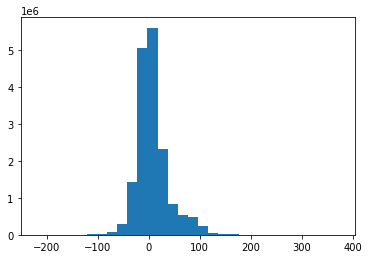

In [32]:
plt.hist(error,bins=30)

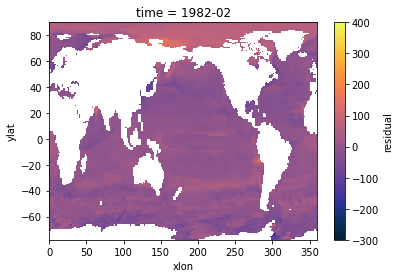

In [33]:
import matplotlib.colors as mcolors
import cmocean as cm

norm = mcolors.Normalize(vmin=-300, vmax = 400)

ds.residual[0].plot(cmap = cm.cm.thermal,norm=norm)

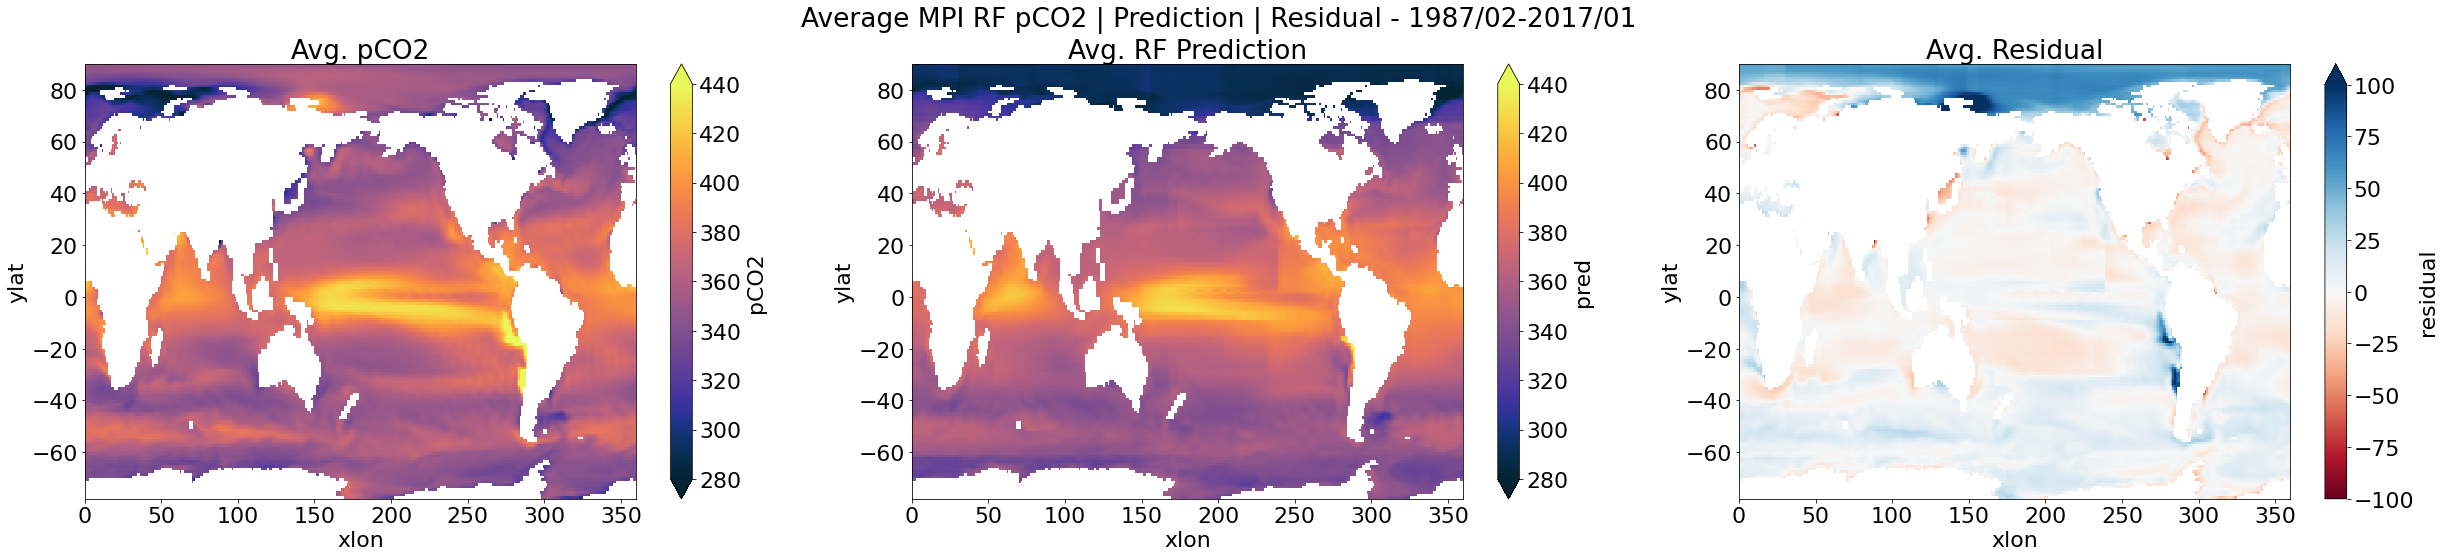

In [34]:
plt.rcParams.update({'font.size': 22})
norm = mcolors.Normalize(vmin=280, vmax = 440)
figure, axis = plt.subplots(1, 3,figsize=(42, 8))

ds_pred.pCO2.mean('time').plot(ax = axis[0],cmap = cm.cm.thermal,norm=norm)
axis[0].set_title("Avg. pCO2")

ds_pred.pred.mean('time').plot(ax = axis[1],cmap = cm.cm.thermal,norm=norm)
axis[1].set_title("Avg. RF Prediction")


norm2 = mcolors.TwoSlopeNorm(vmin = -100, vmax = 100, vcenter=0)

ds.residual.mean('time').plot(ax = axis[2],cmap = "RdBu",norm=norm2)
axis[2].set_title("Avg. Residual")

figure.suptitle("Average MPI RF pCO2 | Prediction | Residual - 1987/02-2017/01")

plt.savefig("../../assets/figure6.0_rf_mpi.jpg")

In [35]:
import statsmodels
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot


print('statsmodels: %s' % statsmodels.__version__)

statsmodels: 0.13.5


In [36]:
combined_tmp.reset_index(inplace=True)
avg_time=combined_tmp.groupby(by="time").mean()
avg_time_res = avg_time["residual"]

In [37]:
avg_time_res = avg_time["residual"]

/burg/glab/users/sk4973/venv2/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


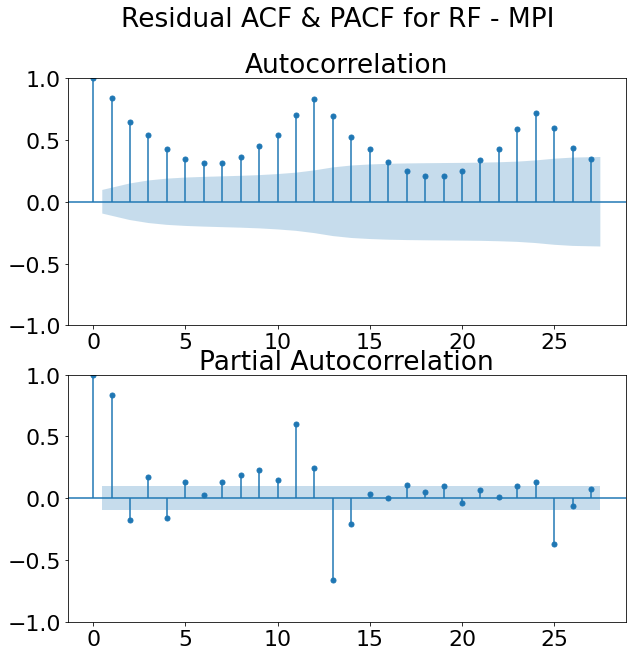

building tree 2 of 20
building tree 6 of 20
building tree 10 of 20
building tree 14 of 20
building tree 18 of 20
building tree 2 of 20
building tree 7 of 20
building tree 11 of 20
building tree 15 of 20
building tree 19 of 20
building tree 3 of 20
building tree 6 of 20
building tree 10 of 20
building tree 13 of 20
building tree 19 of 20
building tree 4 of 20
building tree 8 of 20
building tree 12 of 20
building tree 16 of 20
building tree 20 of 20
building tree 4 of 20
building tree 6 of 20
building tree 9 of 20
building tree 13 of 20
building tree 17 of 20
building tree 1 of 20
building tree 5 of 20
building tree 9 of 20
building tree 14 of 20
building tree 18 of 20
building tree 1 of 20
building tree 5 of 20
building tree 9 of 20
building tree 13 of 20
building tree 17 of 20
building tree 1 of 20
building tree 5 of 20
building tree 10 of 20
building tree 14 of 20
building tree 18 of 20
building tree 2 of 20
building tree 7 of 20
building tree 12 of 20
building tree 16 of 20
building 

In [38]:
fig = pyplot.figure(figsize = (10,10))
pyplot.subplot(211)
plot_acf(avg_time_res, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(avg_time_res, ax=pyplot.gca())

fig.suptitle("Residual ACF & PACF for RF - MPI")

plt.savefig("../../assets/figure6.1_rf_mpi_acf.jpg")
pyplot.show()